In [1]:
from glob import glob
import torch
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from torchvision.transforms import v2 as T
import albumentations as A
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import JaccardIndex
from albumentations.pytorch import ToTensorV2

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
mean = -644.2137072615333
std = 673.311976351113
jaccard = JaccardIndex(task='multiclass', num_classes=3)
# trans = A.Compose([
#     A.Resize(256, 256),
#     A.Normalize(mean, std, max_pixel_value=1),
#     A.RandomBrightnessContrast(brightness_limit=(0, 0.01), contrast_limit=(-0.3,-0.25), p=0.5),
#     A.Crop(x_min=70, y_min=30, x_max=200, y_max=150, p=0.5),
#     A.Resize(256, 256),
# ])

# trans_test = A.Compose([
#     A.Resize(256, 256),
# #     A.Normalize(mean, std, max_pixel_value=1),
# ])

# Создание Dataset

In [3]:
def get_numbers_livers(paths_masks:list) -> set:
        numbers = []
        for path_i in sorted(glob(paths_masks)):
            index_split = path_i.rfind('-') + 1
            num = path_i[index_split:-4]
            if num in numbers:
                raise 'there is already such a number'
            numbers.append(num)
        return numbers
    
    
def convert_number_to_path(number, flag:bool, part='') -> str:
    '''
    flag == True -> path to features
    flag == False -> path to target
    '''
    
    mask_feature = f'/kaggle/input/liver-tumor-segmentation/volume_pt{part}/volume-'
    mask_target = '/kaggle/input/liver-tumor-segmentation/segmentations/segmentation-'
    
    if flag:
        return mask_feature + str(number) + '.nii'
    return mask_target + str(number) + '.nii'


def get_paths_df(paths_features_masks, paths_targets_masks) -> tuple:
    paths_features = []
    paths_targets = []
    numbers_targets = get_numbers_livers(paths_targets_masks)
    for index, path in enumerate(paths_features_masks):
        for num in get_numbers_livers(path):
            if num in numbers_targets:
                paths_features.append(convert_number_to_path(num, True, index + 1))
                paths_targets.append(convert_number_to_path(num, False))
    return np.array(paths_features), np.array(paths_targets)




class LiverDataset:
    def __init__(self, transformation, cnt_read_images3d=5, train=True):
        paths_features_masks = [f'/kaggle/input/liver-tumor-segmentation/volume_pt{i}/*.nii' for i in range(1, 5 + 1)]
        paths_targets_masks = '/kaggle/input/liver-tumor-segmentation/segmentations/*.nii'
        self.train = train
        self.transformation = transformation
        
        self.trans_standart = A.Compose([
            A.Resize(height=256, width=256),
            ToTensorV2(),
        ])
        
        paths_features, paths_targets = get_paths_df(paths_features_masks, paths_targets_masks)
        
        
        
        size = int(len(paths_features) * 0.1)
        mask = np.arange(len(paths_features))
        np.random.seed(0)
        indexs = np.random.choice(mask, size=size, replace=False)
        mask[indexs] = 0
        mask[mask != 0] = 1 
        mask = mask.astype(bool)
        
        if train:
            paths_features = paths_features[mask]
            paths_targets = paths_targets[mask]
        else:
            paths_features = paths_features[~mask]
            paths_targets = paths_targets[~mask]
        
        self.features, self.targets = self.load_data(paths_features, paths_targets, cnt_read_images3d)
  
    
    def __getitem__(self, index):
        img_feature, img_target = self.features[index], self.targets[index]
        trans = self.transformation(image=img_feature, mask=img_target)
        mask = trans['mask'].unsqueeze(0)
        return trans['image'], mask
#         return torch.tensor(self.features[index]), torch.tensor(self.targets[index]).unsqueeze(0)

    
    def __len__(self):
        return len(self.features)
    
    def load_data(self, paths_features, paths_targets, cnt_3d_imgs=10) -> tuple:
        cnt = 0
        features = []
        targets = []
        
#         mean = -644.2137072615333
#         std = 673.311976351113
        
        for index, (path_feature, path_target) in enumerate(zip(paths_features, paths_targets)):
            if cnt == cnt_3d_imgs:
                break
            print(cnt)
            cnt += 1


            img_3d_feature = nib.load(path_feature).get_fdata().transpose(2,0,1)
            img_3d_target = nib.load(path_target).get_fdata().transpose(2,0,1)


            for img_feature, img_target in zip(img_3d_feature, img_3d_target):
                if len(np.unique(img_target)) != 3:
                    continue
                if len(img_target[img_target==2]) <= 250:
                    continue

                img_feature = (img_feature - mean) / std
                trans = self.trans_standart(image=img_feature, mask=img_target)
                img_feature_ = trans['image'].squeeze(0).float()
                img_target_ = trans['mask'].long()

                features.append(img_feature_)
                targets.append(img_target_)

        return np.array(features), np.array(targets)

# Аугментация

In [47]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.Resize(height=256, width=256),
#     A.Normalize(mean, std, max_pixel_value=1),
#     A.RandomBrightnessContrast(brightness_limit=(0, 0.01), contrast_limit=(-0.5,-0.25), p=0.5),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Resize(height=256, width=256),
#     A.Normalize(mean, std, max_pixel_value=1),
    ToTensorV2(),
])

In [48]:
cnt = 10000000000
df_train = LiverDataset(transform_train, cnt)
df_test = LiverDataset(transform_val, cnt, train=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


42


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


43


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


44
0
1
2
3
4
5


In [49]:
print(len(df_train))
print(len(df_test))

1391
122


1878
289

# Просмотр изображений в датасетах

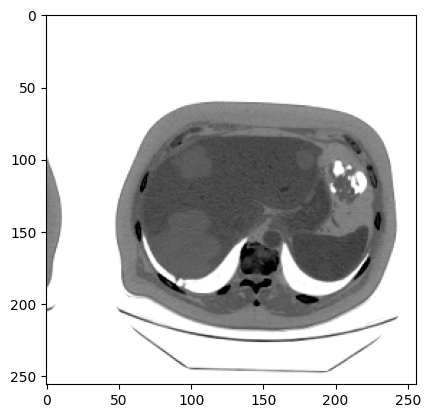

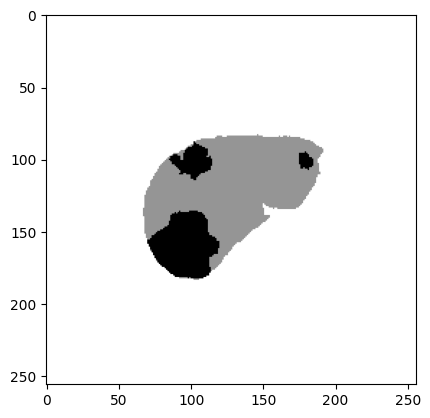

KeyboardInterrupt: 

In [28]:
cnt = 0
for x ,y in df_train:
    cnt += 1
    if cnt < 200:
        continue
#     print(x.shape)
    plt.imshow(x.squeeze(0), cmap='Greys')
    plt.show()
    plt.imshow(y.squeeze(0), cmap='Greys')
    plt.show()
    time.sleep(1)
    clear_output()

# DataLoader

In [50]:
batch_size = 8
tr_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

In [51]:
for x,y in tr_loader:
    print(x.shape,y.shape)
    break

torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


# Получение данных для нормализации

In [ ]:
mean = np.empty(len(df_train))
std = np.empty(len(df_train))
for i, (x, y) in enumerate(df_train):
    mean[i] = x.mean()
    std[i] = x.std()
mean = mean.mean()
std = std.mean()

In [ ]:
mean, std

# Модель UNET

In [75]:
def conv_plus_conv(in_channels: int, out_channels: int):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(1, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4)

        self.bottleneck = conv_plus_conv(base_channels * 8, base_channels * 8)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        residual1 = self.down1(x)  
        x = self.downsample(residual1) 

        residual2 = self.down2(x)  
        x = self.downsample(residual2)
        
        residual3 = self.down3(x)
        x = self.downsample(residual3)
        
        residual4 = self.down4(x)
        x = self.downsample(residual4) 
        
        x = self.bottleneck(x) 
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual4), dim=1)
        x = self.up4(x)
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual3), dim=1)
        x = self.up3(x)
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual1), dim=1)  
        x = self.up1(x)  

        return self.out(x)

In [76]:
def train(model, tr_loader):
    model.train()

    train_loss = 0
    jaccard_cnt = 0

    for x, y in tqdm(tr_loader, desc='Train'):
        x, y = x.to(device).float(), y.to(device).float()

        optimizer.zero_grad()

        pred = model(x)

        loss = loss_fn(pred.reshape(8, 3, -1), y.reshape(8, -1).long())

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        pred = model(x).squeeze(0).max(dim=1)[1].cpu()
#         print(x[0].squeeze(0).shape, pred[0].shape, y[0].squeeze(1).squeeze(0).shape)
#         fig,ax = plt.subplots(1,3)
#         ax[0].imshow(x[0].squeeze(0).cpu())
#         ax[1].imshow(y[0].squeeze(1).squeeze(0).cpu())
#         ax[2].imshow(pred[0])
#         plt.show()
        jaccard_cnt += jaccard(pred, y.squeeze(1).cpu()).item()
    
    if scheduler._step_count < 25:
        scheduler.step()

    train_loss /= len(tr_loader)
    jaccard_cnt /= len(tr_loader)
    return (train_loss, jaccard_cnt)

In [77]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    val_loss = 0
    jaccard_cnt = 0

    for x, y in tqdm(loader, desc='Test'):
        x, y = x.to(device).float(), y.to(device).float()

        pred = model(x)

        loss = loss_fn(pred.reshape(8, 3, -1), y.reshape(8, -1).long())

        val_loss += loss.item()

        pred = model(x).squeeze(0).max(dim=1)[1].cpu()
        
#         fig,ax = plt.subplots(1,3)
#         ax[0].imshow(x[0].squeeze(0).cpu())
#         ax[1].imshow(y[0].squeeze(1).squeeze(0).cpu())
#         ax[2].imshow(pred[0])
#         plt.show()
        
        jaccard_cnt += jaccard(pred, y.squeeze(1).cpu()).item()

    val_loss /= len(loader)
    
    jaccard_cnt /= len(loader)
    return (val_loss, jaccard_cnt)

In [79]:
def plot_stats(train_loss, valid_loss, train_jaccard, val_jaccard):
    plt.figure(figsize=(16, 8))

    plt.title('loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.ylim(0,0.25)
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title('jaccard')
    
    plt.plot(train_jaccard, label='Train jaccard')
    plt.plot(val_jaccard, label='Valid jaccard')
    plt.legend()
    plt.grid()

    plt.show()

In [80]:
def epoh_train(model, tr_loader, valid_loader, num_epochs):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, tr_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()
        
        print('lr:', scheduler.get_last_lr()[0])
        print('tr_loss:', train_loss)
        print('val_loss:', valid_loss)
        
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
        )

In [81]:
unet_model = UNET()
unet_model = unet_model.to(device)

In [99]:
torch.save(unet_model, 'unet_tumor_08')

In [ ]:
unet_model = torch.load('/kaggle/input/model-unet-w/unet_tumor_08')

In [97]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)

lr: 0.0001
tr_loss: 0.013617249700978312
val_loss: 0.025231845987339813


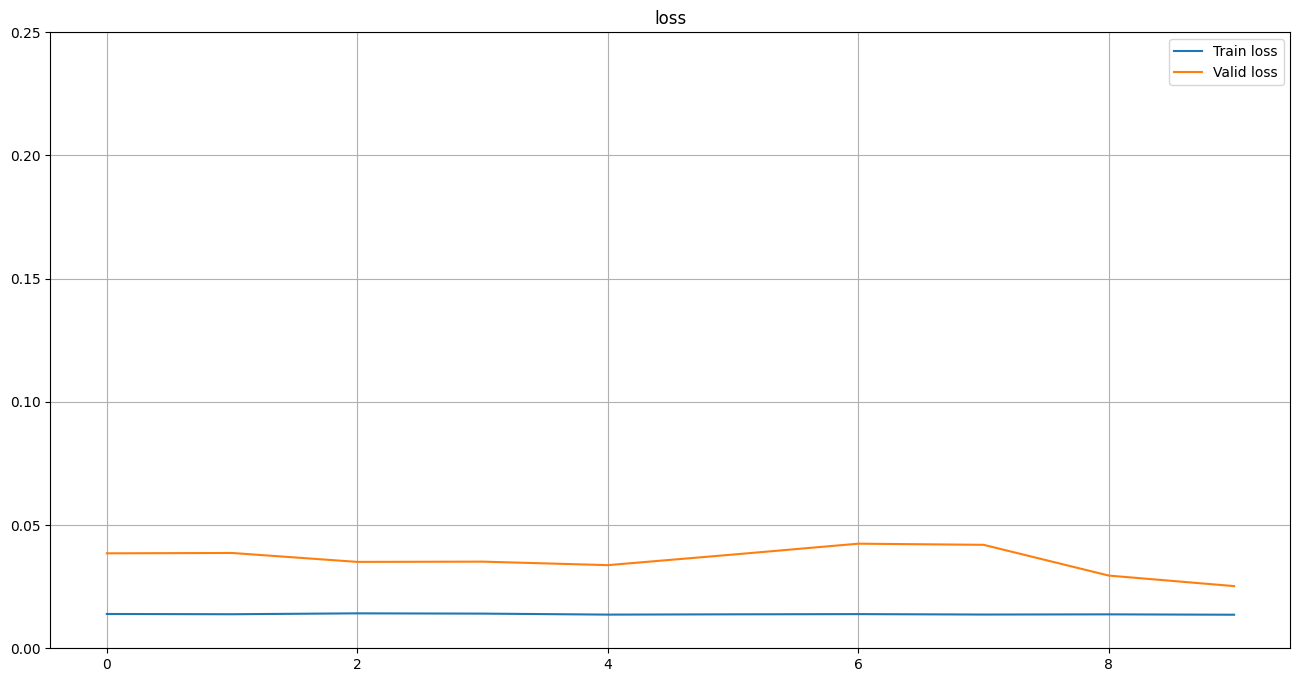

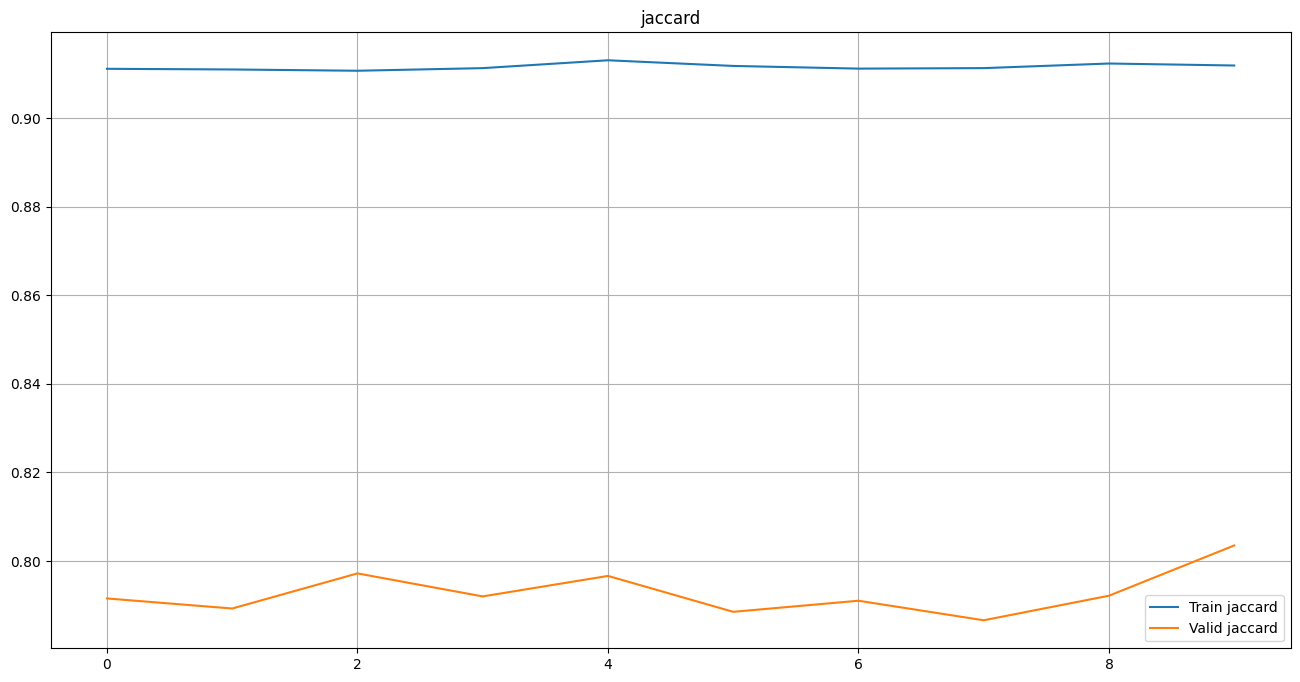

Train:  10%|█         | 18/173 [00:03<00:30,  5.02it/s]


KeyboardInterrupt: 

In [98]:
epoh_train(unet_model, tr_loader, val_loader, 50)

In [106]:
# loss_fn = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
# # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# epochs = 50
# for epoch in range(epochs):
#     unet_model.train()
#     loss_val = 0
#     acc_val = 0
#     for sample in (pbar := tqdm(tr_loader)):
#         img, mask = sample
#         img = img.to(device).float()
#         mask = mask.to(device).float()
#         optimizer.zero_grad()
        
#         pred = (unet_model(img))
    
#         loss = loss_fn(pred.reshape(8, 3, -1), mask.reshape(8, -1).long())

#         loss.backward()
#         loss_item = loss.item()
#         loss_val += loss_item
    
#         optimizer.step()
    
#     fig, ax = plt.subplots(1,2)
#     x = df_train[100][0]
#     ax[0].imshow(x.squeeze(0))
#     x = torch.tensor(x).float().squeeze(0)
#     unet_model.eval()
#     with torch.no_grad():
#         pred = unet_model(x.unsqueeze(0).unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1].cpu()
#     ax[1].imshow(pred)
#     plt.show()
    
#     scheduler.step()
#     print(f'{loss_val/len(tr_loader)}\t lr: {scheduler.get_last_lr()}')

In [22]:
# testing = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
# #     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
#     A.Resize(height=256, width=256),
#     A.Normalize(mean, std, max_pixel_value=1),
# #     A.RandomBrightnessContrast(brightness_limit=(0, 0.01), contrast_limit=(-0.5,-0.25), p=1),
#     ToTensorV2(),
# ])

/tmp/ipykernel_34/2839733912.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float().squeeze(0)
/tmp/ipykernel_34/2839733912.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).long()


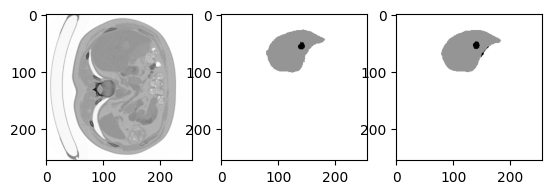

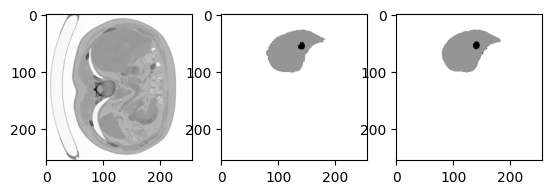

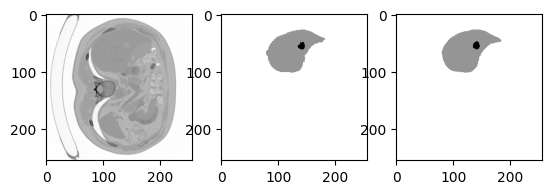

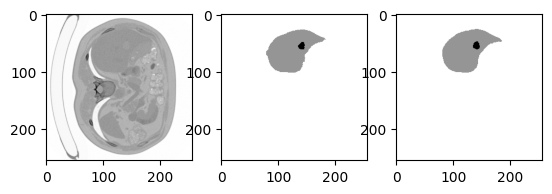

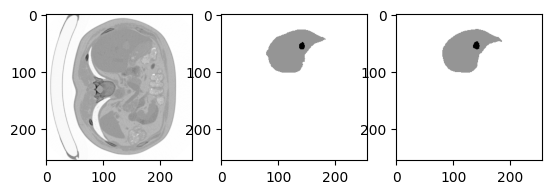

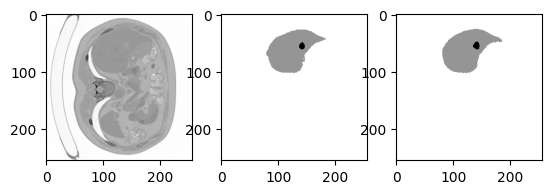

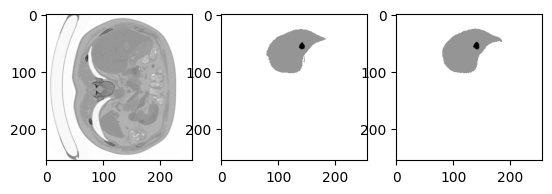

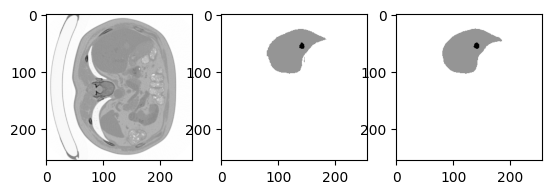

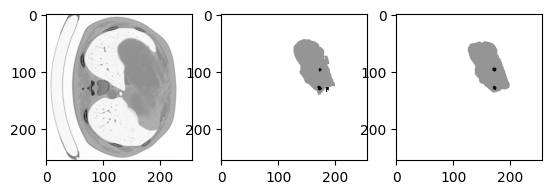

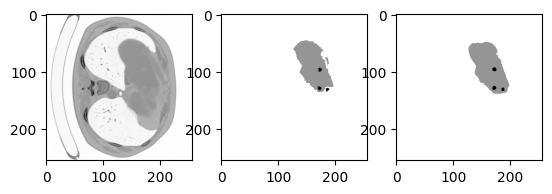

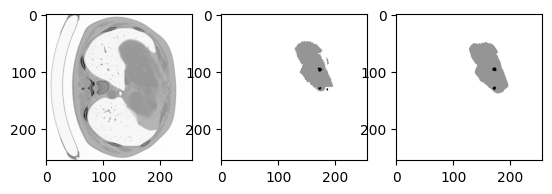

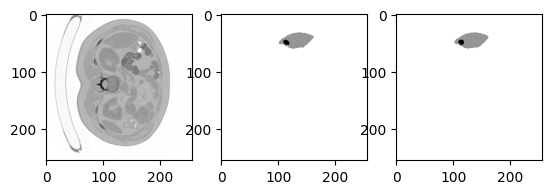

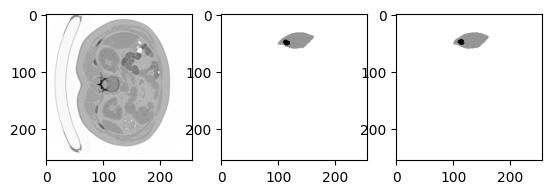

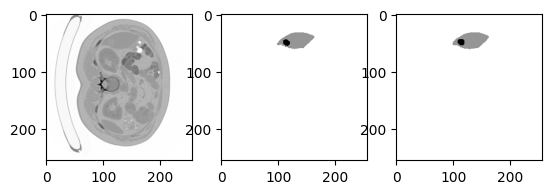

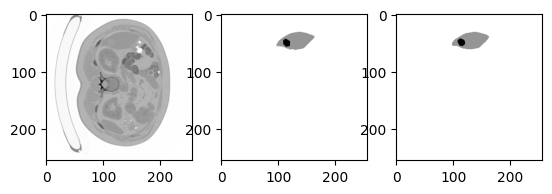

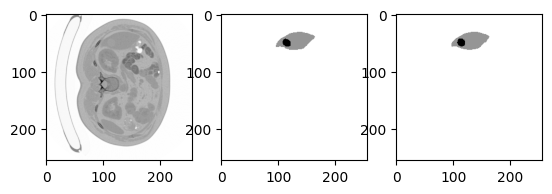

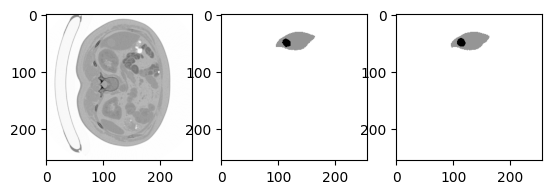

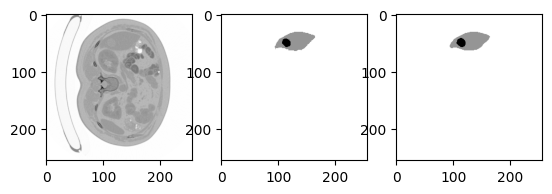

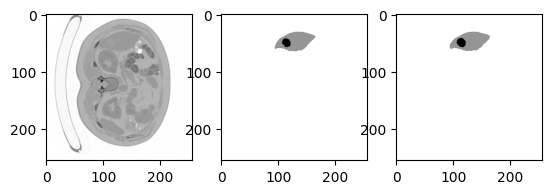

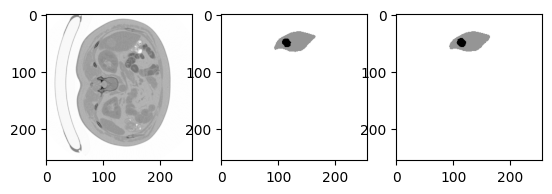

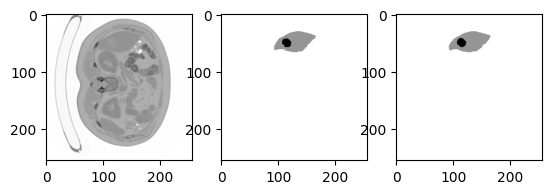

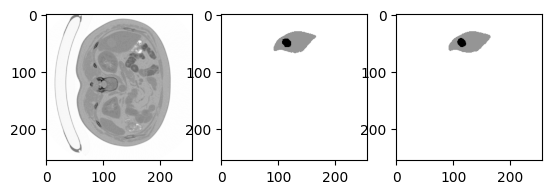

KeyboardInterrupt: 

In [108]:
unet_model.eval()
cnt = 0
jaccard = JaccardIndex(task='multiclass', num_classes=3)
jaccard_cnt = 0
for x, y in df_test:
    cnt += 1
    if cnt < 30:
        continue
    fig, ax = plt.subplots(1,3)
    
#     x,y = x.numpy().squeeze(0), y.numpy().squeeze(0)
#     print(x.shape, y.shape)
#     t = testing(image=x, mask=y)
    
#     x, y = t['image'], t['mask']
    
    ax[0].imshow(x.squeeze(0), cmap='Greys')
    ax[1].imshow(y.squeeze(0), cmap='Greys')
    
    x = torch.tensor(x).float().squeeze(0)
    y = torch.tensor(y).long()
    
    with torch.no_grad():
        pred = unet_model(x.unsqueeze(0).unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1].cpu()
    
    jaccard_cnt += jaccard(pred, y.squeeze(0)).item()

    ax[2].imshow(pred, cmap='Greys')
    plt.show()
    
#     time.sleep(1)
#     clear_output()
print(jaccard_cnt / cnt)